In [1]:
import os 
cwd = os.getcwd()

os.chdir('../')
cwd = os.getcwd()
print(cwd)

os.chdir('./code/')
cwd = os.getcwd()
print(cwd)

import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.metrics import  roc_auc_score

import pickle 
import logging


# from config.config import SQLQuery
# querySno = SQLQuery('snowflake')

/Users/shashankgupta/Documents/code/git_project/plaid_credit
/Users/shashankgupta/Documents/code/git_project/plaid_credit/Code


In [2]:
from preprocess import Convert,MissingValues,Outlier,FeatureSelection
from feature_transformation import Scaler,Transform,Selection
from model_building import split_test_train, feature_encoding, classification_models
from model_evaluations import model_metrics, feature_importance, probability_bins, cross_validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# object initiation 
tf = Transform()
sel = Selection()
ft = FeatureSelection()
cv = Convert()
mv = MissingValues()
ot = Outlier()

# set seed
seed = 9

In [3]:
corr_arr = 0.4 # person correlation coefficient # change it to 0.5
vif_arr = 5 # vif coefficient
features_arr = 10 # total number of features to be selected from backward feature selection
iv_upper_limit = 0.5 # upper threshold of iv # change it to 0.6
iv_lower_limit = 0.02 # lower threshold of iv

In [4]:
df_raw = pd.read_pickle('/Users/shashankgupta/Documents/code/git_project/plaid_credit/data/final_dataset_2.pkl')
df_raw.shape

(646, 255)

In [5]:
# excluding stddev features
keep_stddev_cols = ['stddev_credit_amt_3M']
stddev_cols = list(df_raw.loc[:,df_raw.columns.str.contains('stddev')].columns)

keep_cols = list(set(list(df_raw.columns)).difference(set(stddev_cols))) + keep_stddev_cols


df_raw = df_raw[keep_cols]
df_raw.shape

(646, 219)

In [6]:
df_raw['txn_flag'].value_counts()

txn_flag
1.0    637
0.0      9
Name: count, dtype: int64

In [7]:
df_raw = df_raw[df_raw['txn_flag']==1]
df_raw.shape

(637, 219)

In [8]:
df_raw = df_raw.drop(['business_id', 'lending_business_id','decision_date','drawn_flag', 'everDPD_15', 'fico_score','txn_flag'], axis=1)
df_raw.shape

(637, 212)

In [9]:
## train-test split

# train test split
x_train, y_train, x_test, y_test = split_test_train(df_raw, target_column='target', test_size=0.3, random_state=seed)
print(f'{x_train.shape = }', '|' ,f'{y_train.shape = }', '|' ,f'{x_test.shape = }', '|' ,f'{y_test.shape = }')


# copy to df
df = x_train.copy(deep=True)

x_train.shape = (445, 211) | y_train.shape = (445,) | x_test.shape = (192, 211) | y_test.shape = (192,)


In [10]:
# Treating missing values
df = df.fillna(0)

In [11]:
feat_list = ['stddev_credit_amt_3M', 'shops_amt_3M','pos_size_1M',
               'loans_amt_6M','ratio_amt_credits_less_100_credits_grt_500_3M',
               'median_credit_amt_1M','ratio_pos_size_1M_6M','median_ecom_amt_6M',
                'pos_count_3M','median_pos_amt_3M',
                'count_credits_grt_500_3M','loans_size_6M','sum_credits_grt_500_1M','ach_count_6M']

df['target'] = df_raw['target']

In [12]:
## optimal binning woe

import optbinning as optb
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.binning.binning_statistics import BinningTable

df_temp = df[feat_list].copy()
df_temp['target'] = df['target']
df_temp = df_temp.fillna(0)

(CVXPY) Jul 03 10:38:39 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 03 10:38:39 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


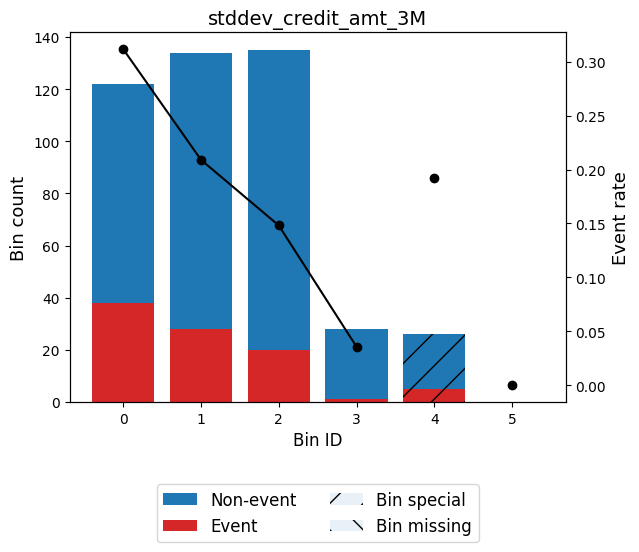

In [13]:
# 1
Xt= df_temp['stddev_credit_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='stddev_credit_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_stddev_credit_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [14]:
ob_stddev_credit_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 578.24)",122,0.274157,84,38,0.311475,-0.551449,0.096549,0.011918
1,"[578.24, 1274.05)",134,0.301124,106,28,0.208955,-0.013445,0.000055,0.000007
2,"[1274.05, 7645.75)",135,0.303371,115,20,0.148148,0.40452,0.043845,0.005444
3,"[7645.75, inf)",28,0.062921,27,1,0.035714,1.951157,0.128030,0.013868
4,Special,26,0.058427,21,5,0.192308,0.090405,0.000465,0.000058
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.268944,0.031294


In [15]:
# 1
# Var tranform
transformed_vars = df[feat_list].copy()

# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

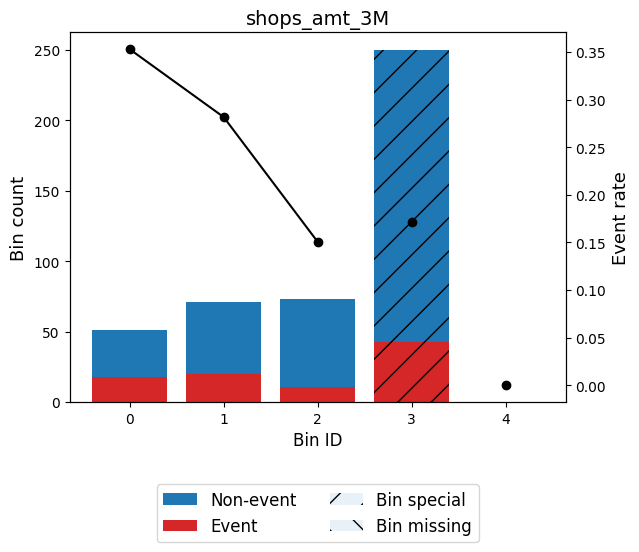

In [16]:
# 2
Xt= df_temp['shops_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='shops_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_shops_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [17]:
ob_shops_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 221.50)",51,0.114607,33,18,0.352941,-0.738544,0.075455,0.009223
1,"[221.50, 2587.99)",71,0.159551,51,20,0.281690,-0.408586,0.029792,0.003698
2,"[2587.99, inf)",73,0.164045,62,11,0.150685,0.38456,0.021563,0.002679
3,Special,250,0.561798,207,43,0.172000,0.226839,0.026996,0.003367
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.153807,0.018968


In [18]:
# 2
# transform
col         = 'shops_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 221.5), 
                (transformed_vars[col] >= 221.5 ) & (transformed_vars[col] < 2588), 
                transformed_vars[col] >= 2588 ]

choices     = [0.226839,-0.738544,-0.408586,0.38456]
    
transformed_vars["shops_amt_3M"] = np.select(conditions, choices, default=np.nan)

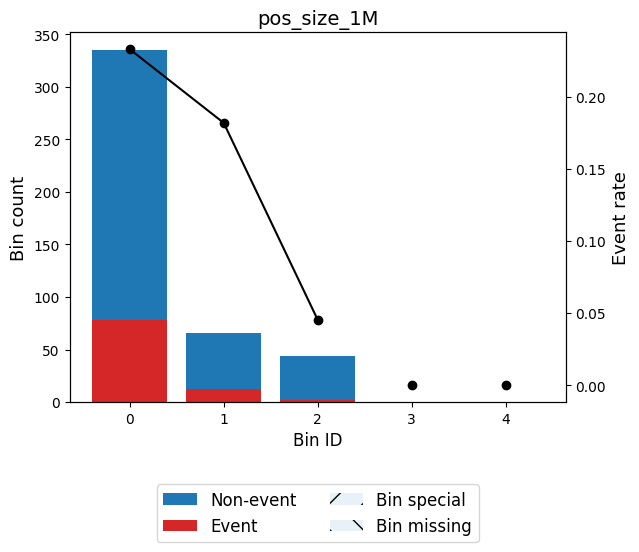

In [19]:
# 3
Xt= df_temp['pos_size_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_size_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_size_1M= optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [20]:
ob_pos_size_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 235.11)",335,0.752809,257,78,0.232836,-0.152312,0.018244,0.002278
1,"[235.11, 979.44)",66,0.148315,54,12,0.181818,0.159398,0.003593,0.000449
2,"[979.44, inf)",44,0.098876,42,2,0.045455,1.699843,0.165294,0.018486
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.187131,0.021213


In [21]:
# 3
# transform
col         = 'pos_size_1M'
conditions  = [ transformed_vars[col] < 235.11, 
                (transformed_vars[col] >= 235.11 ) & (transformed_vars[col] < 979.44), 
                transformed_vars[col] >= 979.44 ]

choices     = [-0.152312,0.159398,1.699843]
    
transformed_vars["pos_size_1M"] = np.select(conditions, choices, default=np.nan)

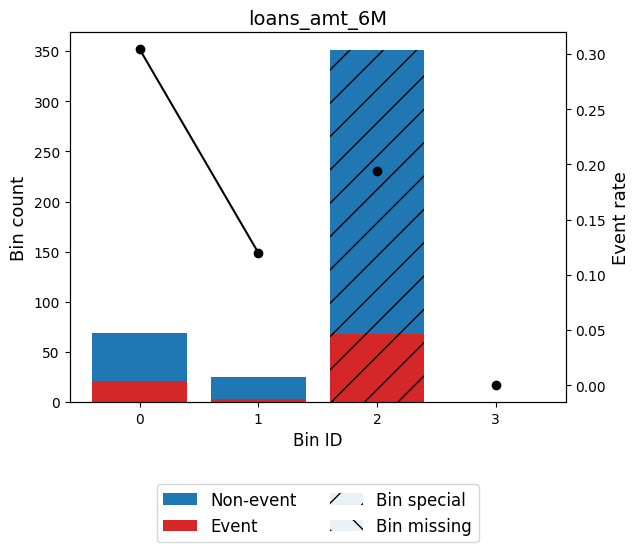

In [22]:
# 4
Xt= df_temp['loans_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='loans_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_loans_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [23]:
ob_loans_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 21503.36)",69,0.155056,48,21,0.304348,-0.518001,0.047803,0.005909
1,"[21503.36, inf)",25,0.056180,22,3,0.120000,0.647751,0.019247,0.002365
2,Special,351,0.788764,283,68,0.193732,0.08126,0.005084,0.000635
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.072135,0.008910


In [24]:
# 4
# transform
col         = 'loans_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 21503),
                transformed_vars[col] >= 21503 ]

choices     = [0.08126,-0.518001,0.647751]
    
transformed_vars["loans_amt_6M"] = np.select(conditions, choices, default=np.nan)

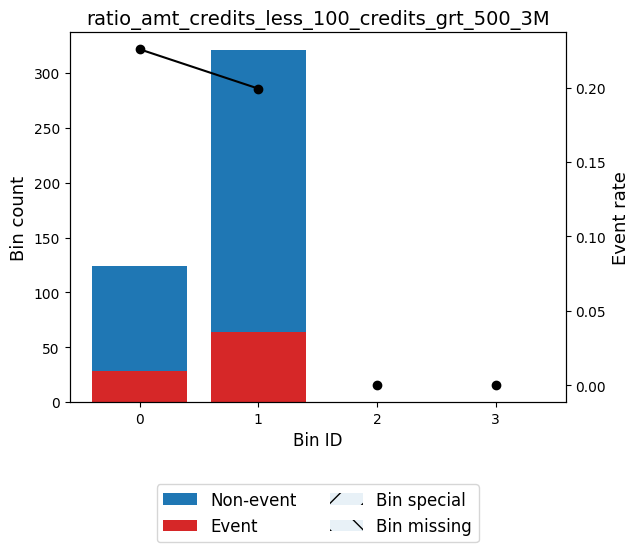

In [25]:
# 5
Xt= df_temp['ratio_amt_credits_less_100_credits_grt_500_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_amt_credits_less_100_credits_grt_500_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_amt_credits_less_100_credits_grt_500_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [26]:
ob_ratio_amt_credits_less_100_credits_grt_500_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",124,0.278652,96,28,0.225806,-0.112536,0.003645,0.000455
1,"[0.00, inf)",321,0.721348,257,64,0.199377,0.045514,0.001474,0.000184
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.005120,0.000640


In [27]:
# 5
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.112536,0.045514]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

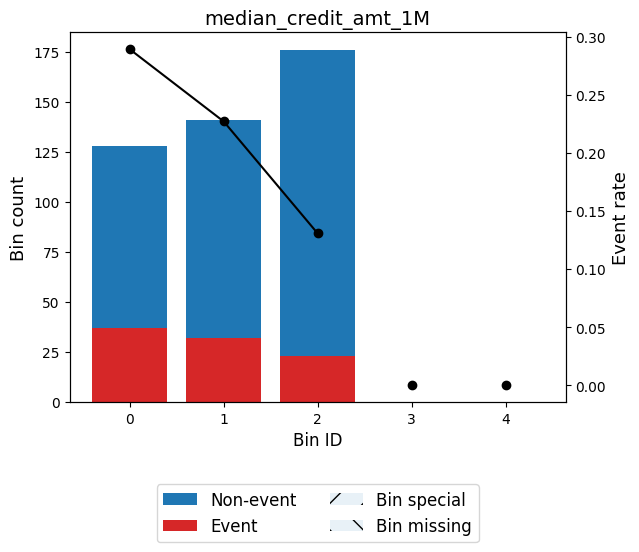

In [28]:
# 6
Xt= df_temp['median_credit_amt_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_credit_amt_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_credit_amt_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [29]:
ob_median_credit_amt_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 102.00)",128,0.287640,91,37,0.289062,-0.444738,0.064213,0.007961
1,"[102.00, 475.21)",141,0.316854,109,32,0.226950,-0.119068,0.004649,0.000581
2,"[475.21, inf)",176,0.395506,153,23,0.130682,0.550264,0.100934,0.012460
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.169795,0.021002


In [30]:
# 6
# transform
col         = 'median_credit_amt_1M'
conditions  = [ transformed_vars[col] < 102,
                (transformed_vars[col] >= 102 ) & (transformed_vars[col] < 475.2),
                transformed_vars[col] >= 475.2 ]

choices     = [-0.444738,-0.119068,0.550264]
    
transformed_vars["median_credit_amt_1M"] = np.select(conditions, choices, default=np.nan)

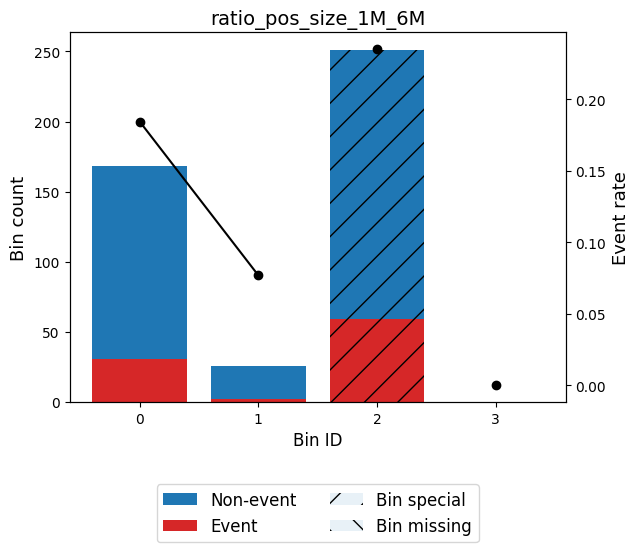

In [31]:
# 7
Xt= df_temp['ratio_pos_size_1M_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_pos_size_1M_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_pos_size_1M_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [32]:
ob_ratio_pos_size_1M_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.21)",168,0.377528,137,31,0.184524,0.141314,0.007228,0.000903
1,"[1.21, inf)",26,0.058427,24,2,0.076923,1.140227,0.052735,0.006256
2,Special,251,0.564045,192,59,0.235060,-0.164722,0.016043,0.002003
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.076006,0.009162


In [33]:
# 7
# transform
col         = 'ratio_pos_size_1M_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.21),
                transformed_vars[col] >= 1.21 ]

choices     = [-0.164722,0.141314,1.140227]
    
transformed_vars["ratio_pos_size_1M_6M"] = np.select(conditions, choices, default=np.nan)

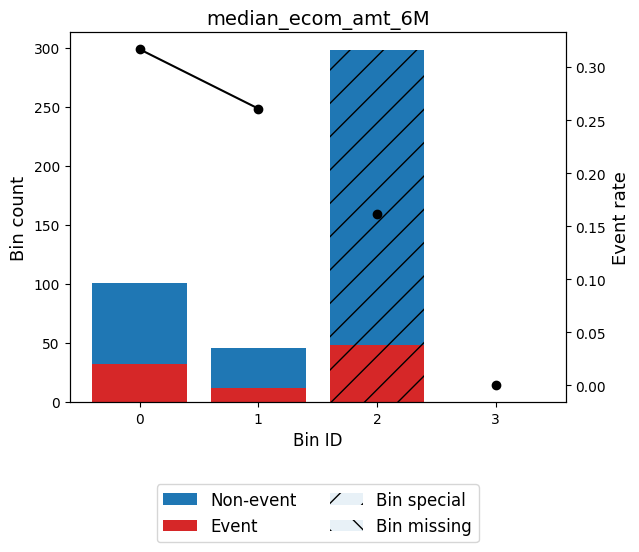

In [34]:
# 8
Xt= df_temp['median_ecom_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_ecom_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending', special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_ecom_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [35]:
ob_median_ecom_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 49.74)",101,0.226966,69,32,0.316832,-0.576309,0.087806,0.010826
1,"[49.74, inf)",46,0.103371,34,12,0.260870,-0.303226,0.010345,0.001288
2,Special,298,0.669663,250,48,0.161074,0.30558,0.056983,0.007095
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.155134,0.019210


In [36]:
# 8
# transform
col         = 'median_ecom_amt_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 49.74),
                transformed_vars[col] >= 49.74 ]

choices     = [0.30558,-0.576309,-0.303226]
    
transformed_vars["median_ecom_amt_6M"] = np.select(conditions, choices, default=np.nan)

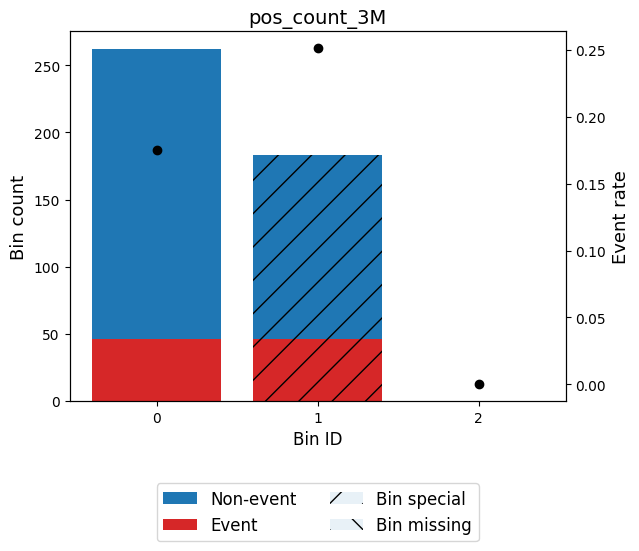

In [37]:
# 9
Xt= df_temp['pos_count_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_count_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending', special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_count_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [38]:
ob_pos_count_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",262,0.588764,216,46,0.175573,0.201958,0.022599,0.002820
1,Special,183,0.411236,137,46,0.251366,-0.25334,0.028348,0.003534
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.050947,0.006354


In [39]:
# 9
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

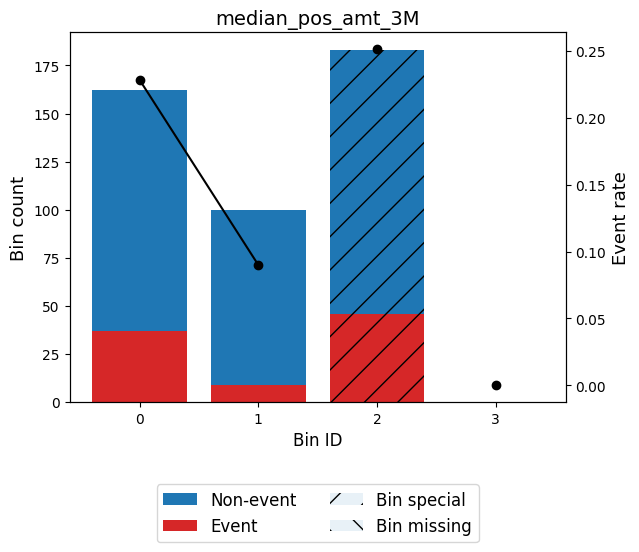

In [40]:
# 10
Xt= df_temp['median_pos_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_pos_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_pos_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [41]:
ob_median_pos_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 486.25)",162,0.364045,125,37,0.228395,-0.127284,0.006118,0.000764
1,"[486.25, inf)",100,0.224719,91,9,0.090000,0.968955,0.154998,0.018651
2,Special,183,0.411236,137,46,0.251366,-0.25334,0.028348,0.003534
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.189465,0.022949


In [42]:
# 10
# transform
col         = 'median_pos_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 486.25),
                transformed_vars[col] >= 486.25 ]

choices     = [-0.25334,-0.127284,0.968955]
    
transformed_vars["median_pos_amt_3M"] = np.select(conditions, choices, default=np.nan)

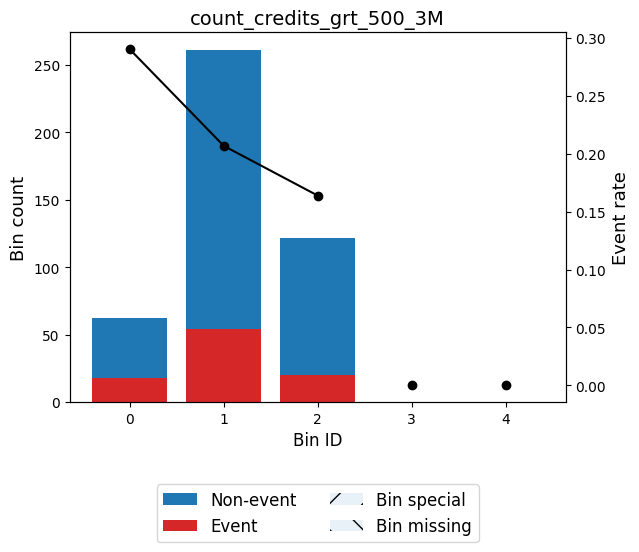

In [43]:
# 11
Xt= df_temp['count_credits_grt_500_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='count_credits_grt_500_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_count_credits_grt_500_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [44]:
ob_count_credits_grt_500_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",62,0.139326,44,18,0.290323,-0.450862,3.201401e-02,3.968197e-03
1,"[1.50, 15.50)",261,0.586517,207,54,0.206897,-0.000945,5.236235e-07,6.545294e-08
2,"[15.50, inf)",122,0.274157,102,20,0.163934,0.284561,2.036334e-02,2.536864e-03
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,445,1.000000,353,92,0.206742,,5.237787e-02,6.505127e-03


In [45]:
# 11
# transform
col         = 'count_credits_grt_500_3M'
conditions  = [ transformed_vars[col] < 1.5,
                (transformed_vars[col] >= 1.5 ) & (transformed_vars[col] < 15.5),
                transformed_vars[col] >= 15.5 ]

choices     = [-0.450862,-0.000945,0.284561]
    
transformed_vars["count_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

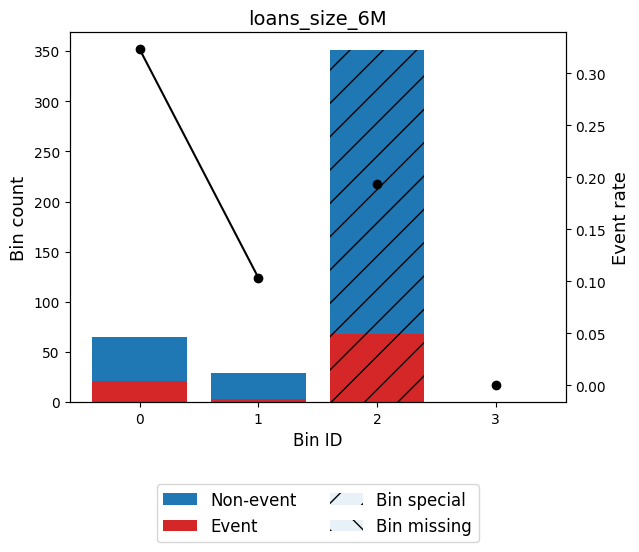

In [46]:
# 12
Xt= df_temp['loans_size_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='loans_size_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_loans_size_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [47]:
ob_loans_size_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3316.67)",65,0.146067,44,21,0.323077,-0.605012,0.062688,0.007719
1,"[3316.67, inf)",29,0.065169,26,3,0.103448,0.814805,0.033444,0.004069
2,Special,351,0.788764,283,68,0.193732,0.08126,0.005084,0.000635
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.101217,0.012423


In [48]:
# 12
# transform
col         = 'loans_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 3317),
                transformed_vars[col] >= 3317 ]

choices     = [0.08126,-0.605012,0.814805]
    
transformed_vars["loans_size_6M"] = np.select(conditions, choices, default=np.nan)

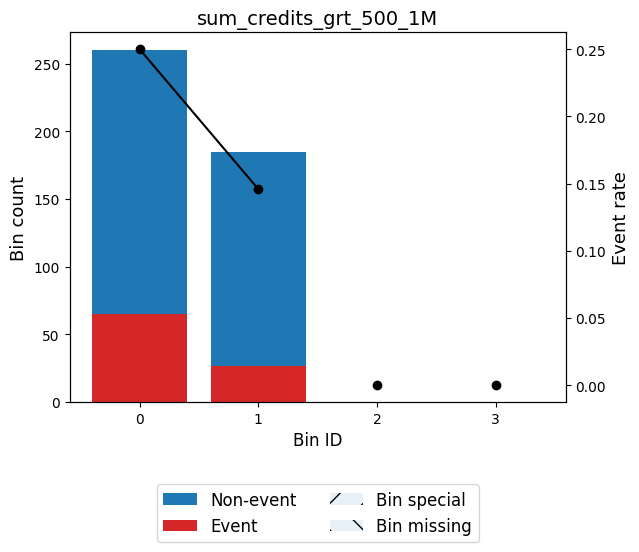

In [49]:
# 13
Xt= df_temp['sum_credits_grt_500_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='sum_credits_grt_500_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_sum_credits_grt_500_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [50]:
ob_sum_credits_grt_500_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6586.72)",260,0.58427,195,65,0.250000,-0.246067,0.037922,0.004728
1,"[6586.72, inf)",185,0.41573,158,27,0.145946,0.422079,0.065048,0.008071
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.00000,353,92,0.206742,,0.102971,0.012800


In [51]:
# 13
# transform
col         = 'sum_credits_grt_500_1M'
conditions  = [ transformed_vars[col] < 6587,
                transformed_vars[col] >= 6587 ]

choices     = [-0.246067,0.422079]
    
transformed_vars["sum_credits_grt_500_1M"] = np.select(conditions, choices, default=np.nan)

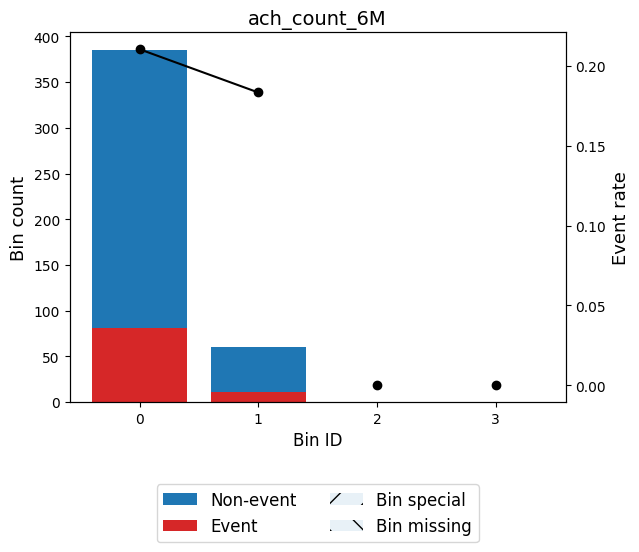

In [52]:
# 14
Xt= df_temp['ach_count_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ach_count_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ach_count_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [53]:
ob_ach_count_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.50)",385,0.865169,304,81,0.210390,-0.022101,0.000425,0.000053
1,"[6.50, inf)",60,0.134831,49,11,0.183333,0.149246,0.002872,0.000359
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.003298,0.000412


In [54]:
# 14
# transform
col         = 'ach_count_6M'
conditions  = [ transformed_vars[col] < 6.5,
                transformed_vars[col] >= 6.5 ]

choices     = [-0.022101,0.149246]
    
transformed_vars["ach_count_6M"] = np.select(conditions, choices, default=np.nan)

#### Model fitting

In [55]:
# copy vars
X_train = transformed_vars.copy()

# hyperparameters
params_log_reg = {'penalty': 'l2',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': 'balanced'}

# model fit
logreg_model = classification_models(X_train[feat_list], y_train, params_log_reg, models=['log_reg'])

In [56]:
# train cv scores
cv_scores = cross_validation(logreg_model, X_train[feat_list], y_train, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.74 0.67 0.64]
Mean of CV Scores - 0.68


In [57]:
# Feature importance
feat_imp = feature_importance(logreg_model, X_train[feat_list], show_plot=True)

feat_imp.sort_values(by='importance', ascending=False)

,importance
ratio_amt_credits_less_100_credits_grt_500_3M,0.202163
count_credits_grt_500_3M,0.183356
sum_credits_grt_500_1M,0.018701
loans_size_6M,-0.131489
pos_size_1M,-0.183295
ach_count_6M,-0.284374
median_credit_amt_1M,-0.341009
loans_amt_6M,-0.355655
pos_count_3M,-0.434767
median_pos_amt_3M,-0.545962


In [58]:
# binning variable transform
x_test.fillna(0, inplace=True)

transformed_vars = x_test[feat_list]

In [59]:
# 1
# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 2
# transform
col         = 'shops_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 221.5), 
                (transformed_vars[col] >= 221.5 ) & (transformed_vars[col] < 2588), 
                transformed_vars[col] >= 2588 ]

choices     = [0.226839,-0.738544,-0.408586,0.38456]
    
transformed_vars["shops_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 3
# transform
col         = 'pos_size_1M'
conditions  = [ transformed_vars[col] < 235.11, 
                (transformed_vars[col] >= 235.11 ) & (transformed_vars[col] < 979.44), 
                transformed_vars[col] >= 979.44 ]

choices     = [-0.152312,0.159398,1.699843]
    
transformed_vars["pos_size_1M"] = np.select(conditions, choices, default=np.nan)

# 4
# transform
col         = 'loans_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 21503),
                transformed_vars[col] >= 21503 ]

choices     = [0.08126,-0.518001,0.647751]
    
transformed_vars["loans_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 5
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.112536,0.045514]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

# 6
# transform
col         = 'median_credit_amt_1M'
conditions  = [ transformed_vars[col] < 102,
                (transformed_vars[col] >= 102 ) & (transformed_vars[col] < 475.2),
                transformed_vars[col] >= 475.2 ]

choices     = [-0.444738,-0.119068,0.550264]
    
transformed_vars["median_credit_amt_1M"] = np.select(conditions, choices, default=np.nan)

# 7
# transform
col         = 'ratio_pos_size_1M_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.21),
                transformed_vars[col] >= 1.21 ]

choices     = [-0.164722,0.141314,1.140227]
    
transformed_vars["ratio_pos_size_1M_6M"] = np.select(conditions, choices, default=np.nan)

# 8
# transform
col         = 'median_ecom_amt_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 49.74),
                transformed_vars[col] >= 49.74 ]

choices     = [0.30558,-0.576309,-0.303226]
    
transformed_vars["median_ecom_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 9
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

# 10
# transform
col         = 'median_pos_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 486.25),
                transformed_vars[col] >= 486.25 ]

choices     = [-0.25334,-0.127284,0.968955]
    
transformed_vars["median_pos_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 11
# transform
col         = 'count_credits_grt_500_3M'
conditions  = [ transformed_vars[col] < 1.5,
                (transformed_vars[col] >= 1.5 ) & (transformed_vars[col] < 15.5),
                transformed_vars[col] >= 15.5 ]

choices     = [-0.450862,-0.000945,0.284561]
    
transformed_vars["count_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

# 12
# transform
col         = 'loans_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 3317),
                transformed_vars[col] >= 3317 ]

choices     = [0.08126,-0.605012,0.814805]
    
transformed_vars["loans_size_6M"] = np.select(conditions, choices, default=np.nan)


# 13
# transform
col         = 'sum_credits_grt_500_1M'
conditions  = [ transformed_vars[col] < 6587,
                transformed_vars[col] >= 6587 ]

choices     = [-0.246067,0.422079]
    
transformed_vars["sum_credits_grt_500_1M"] = np.select(conditions, choices, default=np.nan)

# 14
# transform
col         = 'ach_count_6M'
conditions  = [ transformed_vars[col] < 6.5,
                transformed_vars[col] >= 6.5 ]

choices     = [-0.022101,0.149246]
    
transformed_vars["ach_count_6M"] = np.select(conditions, choices, default=np.nan)

In [60]:
# copy
X_test = transformed_vars.copy()

In [61]:
# test cv scores
cv_scores = cross_validation(logreg_model, X_test[feat_list], y_test, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.68 0.59 0.57]
Mean of CV Scores - 0.61


In [62]:
## Model Evaluation - KS & ROC AUC

def ks(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'], 5, duplicates = 'drop')
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # kstable.index = range(1,len(data['bucket'].unique())+1)
    # kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    # print(kstable)
    
    # Display KS
    # print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable

In [63]:
# predicted proability
train_pred = logreg_model.predict_proba(X_train[feat_list])[:,1]
                                                                     
test_pred = logreg_model.predict_proba(X_test[feat_list])[:,1]


train_ks = ks(y_train, train_pred)
test_ks = ks(y_test, test_pred)



In [64]:
# AUC scores
print('Train AUC = {}'.format(roc_auc_score(y_train, train_pred)))   
  
print('Test AUC = {}'.format(roc_auc_score(y_test, test_pred)))    

Train AUC = 0.7293077965266659
Test AUC = 0.6539473684210527


In [65]:
train_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
0,0.611044,0.855591,40.0,49.0,...,43.48%,13.88%,29.6,44.943820
1,0.508884,0.609653,17.0,70.0,...,61.96%,33.71%,28.2,19.540230
2,0.427436,0.508154,21.0,68.0,...,84.78%,52.97%,31.8,23.595506
3,0.274534,0.426618,8.0,83.0,...,93.48%,76.49%,17.0,8.791209
4,0.022513,0.270676,6.0,83.0,...,100.00%,100.00%,-0.0,6.741573


In [66]:
test_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
0,0.628804,0.856461,14.0,25.0,...,35.00%,16.45%,18.6,35.897436
1,0.530722,0.627054,9.0,29.0,...,57.50%,35.53%,22.0,23.684211
2,0.415716,0.527902,7.0,31.0,...,75.00%,55.92%,19.1,18.421053
3,0.316170,0.414219,6.0,32.0,...,90.00%,76.97%,13.0,15.789474
4,0.046981,0.312942,4.0,35.0,...,100.00%,100.00%,0.0,10.256410


In [67]:
def is_column_descending(df, column_name):
    is_descending = df[column_name].is_monotonic_decreasing
    return int(is_descending)

In [68]:
def get_model_results(X_train, y_train, X_test, y_test, feat_list,params_log_reg, output_df):
    # model fitting
    logreg_model = classification_models(X_train[feat_list], y_train, params_log_reg, models=['log_reg'])

    #cv scores
    cv_scores = cross_validation(logreg_model, X_train[feat_list], y_train, scoring='roc_auc', folds=3, seed=seed)
    train_cv_score = np.round(np.mean(cv_scores),2)
    cv_scores = cross_validation(logreg_model, X_test[feat_list], y_test, scoring='roc_auc', folds=3, seed=seed)
    test_cv_score = np.round(np.mean(cv_scores),2)
    
    # predicted proability
    train_pred = logreg_model.predict_proba(X_train[feat_list])[:,1]                                                             
    test_pred = logreg_model.predict_proba(X_test[feat_list])[:,1]

    #AUC
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)

    # Rank-order
    train_ks = ks(y_train, train_pred)
    test_ks = ks(y_test, test_pred)

    train_ro = is_column_descending(train_ks, 'bad_rate')
    test_ro = is_column_descending(test_ks, 'bad_rate')

    temp = {'feat_list' : [feat_list],\
            'feat_length' : len(feat_list),\
            'train_cv_score' : train_cv_score,\
            'test_cv_score' : test_cv_score,\
            'train_auc' : train_auc,\
            'test_auc' : test_auc,\
            'train_ro' : train_ro,\
            'test_ro' : test_ro}
    output_df = pd.concat([output_df, pd.DataFrame(temp)], ignore_index=True)

    return output_df, temp
    

In [69]:
feat_list

['stddev_credit_amt_3M',
 'shops_amt_3M',
 'pos_size_1M',
 'loans_amt_6M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_ecom_amt_6M',
 'pos_count_3M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M',
 'loans_size_6M',
 'sum_credits_grt_500_1M',
 'ach_count_6M']

In [70]:
from itertools import combinations

def get_subsets_of_length(lst, subset_length):
    subsets = list(combinations(lst, subset_length))
    return subsets 

# subsets = get_subsets_of_length(feat_list, 9)

In [71]:
output_df = pd.DataFrame(columns = ('feat_list','feat_length','train_cv_score','test_cv_score','train_auc','test_auc','train_ro','test_ro'))
for subset_length in [7,8,9,10,11,12,13]:
    subsets = list(combinations(feat_list, subset_length))
    for i in range(len(subsets)):
        X_train_temp = X_train[list(subsets[i])]
        X_test_temp = X_test[list(subsets[i])]
        # print(subsets[i])
        output_df,temp = get_model_results(X_train_temp, y_train, X_test_temp, y_test, list(subsets[i]),params_log_reg, output_df)


In [72]:
output_df

,feat_list,feat_length,train_cv_score,test_cv_score,train_auc,test_auc,train_ro,test_ro
0,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",7,0.66,0.64,0.690833,0.675164,1,0
1,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",7,0.67,0.66,0.711987,0.661595,0,1
2,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",7,0.66,0.65,0.694390,0.657484,1,0
3,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",7,0.67,0.64,0.697792,0.650822,1,0
4,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",7,0.66,0.65,0.689632,0.669819,1,0
...,...,...,...,...,...,...,...,...
9902,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",13,0.68,0.61,0.729600,0.652138,0,1
9903,"[stddev_credit_amt_3M, shops_amt_3M, pos_size_...",13,0.68,0.61,0.729369,0.657730,0,0
9904,"[stddev_credit_amt_3M, shops_amt_3M, loans_amt...",13,0.69,0.61,0.728461,0.652303,1,1
9905,"[stddev_credit_amt_3M, pos_size_1M, loans_amt_...",13,0.70,0.62,0.719932,0.669079,1,0


In [73]:
output_df['auc_delta'] = output_df['train_auc'] - output_df['test_auc']

In [114]:
output_df[(output_df['train_ro']==1) & (output_df['test_ro']==1) & (output_df['auc_delta']>=0)].sort_values(by=['auc_delta','train_auc'],ascending = [True, False]).head(30)

,feat_list,feat_length,train_cv_score,test_cv_score,train_auc,test_auc,train_ro,test_ro,auc_delta
925,"[stddev_credit_amt_3M, pos_size_1M, loans_amt_...",7,0.67,0.63,0.684321,0.684046,1,1,0.000275
1401,"[stddev_credit_amt_3M, loans_amt_6M, median_cr...",7,0.65,0.63,0.675884,0.675329,1,1,0.000555
4636,"[stddev_credit_amt_3M, pos_size_1M, ratio_amt_...",8,0.67,0.61,0.687939,0.687253,1,1,0.000685
7460,"[stddev_credit_amt_3M, pos_size_1M, ratio_amt_...",9,0.66,0.61,0.687939,0.687253,1,1,0.000685
1091,"[stddev_credit_amt_3M, pos_size_1M, ratio_amt_...",7,0.65,0.63,0.657070,0.656168,1,1,0.000902
3135,"[loans_amt_6M, ratio_amt_credits_less_100_cred...",7,0.64,0.61,0.652774,0.651809,1,1,0.000965
1226,"[stddev_credit_amt_3M, pos_size_1M, ratio_pos_...",7,0.64,0.63,0.660026,0.658799,1,1,0.001227
1014,"[stddev_credit_amt_3M, pos_size_1M, ratio_amt_...",7,0.67,0.61,0.689956,0.687911,1,1,0.002044
4624,"[stddev_credit_amt_3M, pos_size_1M, ratio_amt_...",8,0.67,0.61,0.690171,0.688076,1,1,0.002096
4550,"[stddev_credit_amt_3M, pos_size_1M, loans_amt_...",8,0.67,0.63,0.685398,0.682895,1,1,0.002504


In [ ]:
[926,
9067,
4509,
7384,
7286,
7461,
9033,
4393.
8955,
4497]

In [125]:
output_df.iloc[7468]['feat_list']

['stddev_credit_amt_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M',
 'loans_size_6M',
 'ach_count_6M']

In [129]:
output_df.iloc[4633]['feat_list']

['stddev_credit_amt_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M',
 'loans_size_6M']

In [130]:
output_df.iloc[4624]['feat_list']

['stddev_credit_amt_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'pos_count_3M',
 'median_pos_amt_3M',
 'loans_size_6M']

In [131]:
output_df.iloc[4367]['feat_list']

['stddev_credit_amt_3M',
 'pos_size_1M',
 'loans_amt_6M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M']

In [132]:
output_df.iloc[1014]['feat_list']

['stddev_credit_amt_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'loans_size_6M']

In [102]:
output_df.shape

(9907, 9)